## Sección de Librerías

In [15]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

#Finanzas 
import yfinance as yf
import pypfopt
from pypfopt import EfficientFrontier,plotting

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

## Descarga de lista de activos a escoger

In [2]:
#Opciones precargadas de índices a utilizar para evaluar. 
sp500_components = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()
sp100_components = pd.read_html('https://www.infobolsa.es/acciones/sp100')[0]['Ticker'].to_list()
dowjones_components = pd.read_html('https://www.infobolsa.es/acciones/dowjones')[0]['Ticker'].to_list()
nasdaq100_components = pd.read_html('https://www.infobolsa.es/acciones/nasdaq')[0]['Ticker'].to_list()
dax40_components = pd.read_html('https://www.infobolsa.es/acciones/dax30')[0]['Ticker'].to_list()
eurostoxx50_components = pd.read_html('https://www.infobolsa.es/acciones/eurostoxx50')[0]['Ticker'].to_list()

## Primera parte obtención de los activos para el portafolio

In [3]:
assets = dowjones_components
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  30 of 30 completed


In [4]:
#Obtenemos información de los activos 
#- retornos logaritmicos 
#- profits: Retorno medio esperado. 
#- risk: Desviación estándar del activo. 
returns, assets_info= pre_processing.get_assets_info(prices, 0.99, log_returns=True)

In [5]:
best_assets = ArchievingStrategies.get_best_opt(assets_info, 1e-6)

30it [00:00, 15024.37it/s]


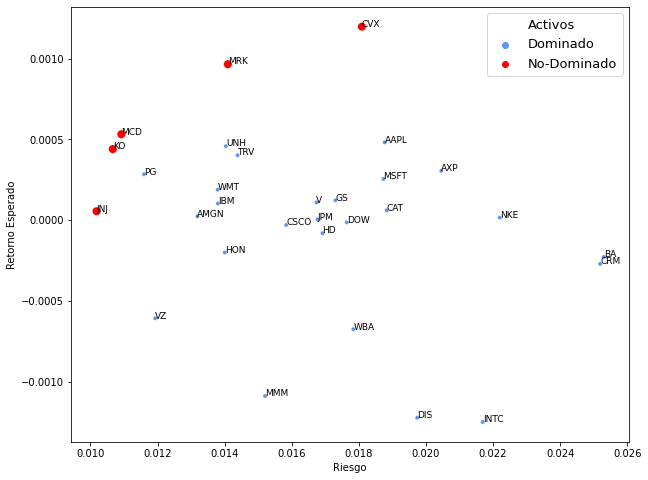

In [6]:
my_plotting.plot_assets(assets_info, best_assets)


## Segunda Parte Definición del Problema

In [16]:
PROFITS, RISK = pre_processing.get_final_assets(returns[best_assets.index])
problem_portfolios = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK)


In [ ]:
from pymoo.optimize import minimize
from pymoo.termination import get_termination

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.population import Population
algorithm = NSGA2(
    pop_size=20,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.5, eta=10),
    mutation=PM(eta=15),
    eliminate_duplicates=True
)

res = minimize(problem_portfolios,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)

all_pop = Population()

for algorithm in res.history:
    all_pop = Population.merge(all_pop, algorithm.off)

X = all_pop.get('X')
F = all_pop.get('F')